In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv('../../Database/DB_v2.csv',index_col=False)
df=df.drop(['Unnamed: 0'],axis=1)
scaler=StandardScaler()


In [3]:
y=df['DEF_PAY']
X=scaler.fit_transform(df.drop(['DEF_PAY'],axis=1))

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import joblib

In [5]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=10):
    skf = StratifiedKFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'balanced_accuracy'}    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    gs = GridSearchCV(model, scoring=scoring,cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='AUC')
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

In [6]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['rbf','linear']

param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
svm = SVC(class_weight='balanced')
gs,_,_=gridSearch(svm,param_grid,X,y,0.2)
joblib.dump(gs, 'gs_svm.pkl') #se guarda el gs para su posterior uso

/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=5240     0
1978     0
7080     0
22716    0
13109    0
        ..
19702    0
19081    0
16547    0
21573    1
4699     0
Name: DEF_PAY, Length: 24000, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


SVC(C=0.1, class_weight='balanced', gamma=0.01)
0.7672020749492721


['gs_svm.pkl']

In [8]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 

def experimentar(X,Y,oversampling=False):

    #Validamos el modelo
    Folds = 10
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = SVC(class_weight='balanced',C=0.1,gamma=0.01,probability=True)
        if oversampling:
            sm = SMOTE(random_state=42)
            Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)
        model.fit(X=Xtrain, y=Ytrain)
        Yest = model.predict_proba(Xtest)
        
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1),normalize=True) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

              precision    recall  f1-score   support

           0       0.85      0.95      0.89     11682
           1       0.68      0.39      0.50      3318

    accuracy                           0.83     15000
   macro avg       0.76      0.67      0.70     15000
weighted avg       0.81      0.83      0.81     15000



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.766029,0.017768,0.659808,0.010845


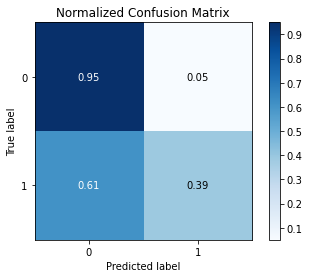

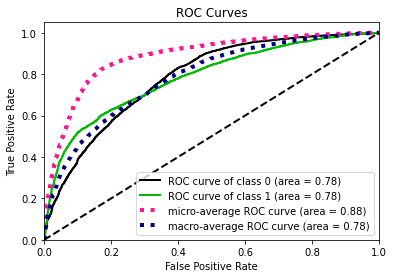

In [9]:
experimentar(X,y)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86     11682
           1       0.51      0.59      0.55      3318

    accuracy                           0.78     15000
   macro avg       0.69      0.71      0.70     15000
weighted avg       0.80      0.78      0.79     15000



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.765609,0.017416,0.7018,0.012478


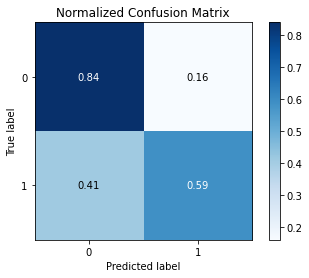

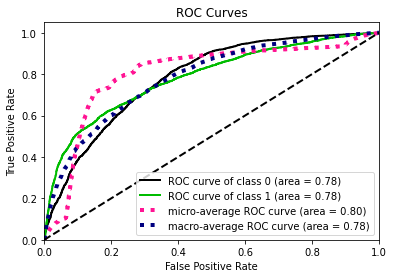

In [10]:
experimentar(X,y,oversampling=True)